One of the most common probability distributions is the normal (or Gaussian) distribution.  Many natural phenomena can be modeled using a normal distribution.  It's also of great importance due to its relation to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

In this post, we'll be reviewing the normal distribution and looking at how to draw samples from it using two methods.  One naive method using the central limit theorem, and another using the [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform).  As usual, some brief coverage of proofs and code will be included to help drive intuition.


## Background

### Normal Distribution

Let's first start off covering some basics.  A normal distribution (also known as a Gaussian distribution) \\(N \sim (\mu, \sigma)\\) has probability density function (PDF) and cumulative density function (CDF) shown here [<sup>[1]</sup>](#fn-1):

$$ f_N(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma}} \tag{1}$$
$$ F_N(x) = \int_{-\infty}^{x}f_N(t) dt  \tag{2}$$

The CDF doesn't have a nice closed form, so we'll just represent it here using the definition of CDF in terms of its PDF.  We can graph the PDF and CDF (images from [Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution)):

![PDF of Normal Distribution](/images/normal_pdf_cdf.png)

The normal distribution is sometimes colloquially known as the "bell curve" because of a it's symmetric hump.  A very common thing with a probability distribution is to *sample* from it.  In other words, we want to randomly generate numbers (i.e. \\(x\\) values) such that the values of \\(x\\) are in proportion to the PDF.  So for the standard normal distribution, \\(N \sim (0, 1) \\) (the red curve in the picture above), most of the values would fall close to somewhere around \\(x=0\\).  In fact, 68% will fall within \\([-1, 1]\\), 95% will fall within \\([-2,2]\\) and 99.7% will fall within \\([-3,3]\\).  This corresponds to \\(\sigma, 2\sigma, 3\sigma\\) from the mean, see this [article](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) for more details.

### Central Limit Theorem

The central limit theorem (CLT) is quite a surprising result relating the sample average of \\(n\\) [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (i.i.d.) random variables and a normal distribution.  To state more precisely: 

> Let \\({X_1, X_2, \ldots, X_n}\\) be \\(n\\) i.i.d. random variables with \\(E(X_i)=\mu\\) 
> and \\(Var(X_i)=\sigma^2\\) and  let \\(S_n = \frac{X_1 + X_2 + \ldots + X_n}{n}\\) be the sample 
> average. Then \\(S_n\\) approximates a normal distribution with mean of \\(\mu\\) and 
> variance of \\(\frac{\sigma^2}{n}\\) for large \\(n\\) (i.e. \\(S_n \approx N(\mu, \frac{\sigma^2}{n})\\))

The surprising result is that \\(X_n\\) can be *any* shape of distribution.  It isn't restricted to just normal distributions.  We can also define the standard normal distribution in terms of \\(S_n\\) by shifting and scaling it:

$$ N(0,1) \approx \frac{S_n - \mu}{\frac{\sigma}{\sqrt{n}}} = \frac{\sqrt{n}(S_n - \mu)}{\sigma} \tag{3} $$

### Comparing Distributions

Since our goal is to implement sampling from a normal distribution, it would be nice to know if we actually did it correctly!  One common way to test if two arbitrary distributions are the same is to use the [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).  In the basic form, we can compare a sample of points with a reference distribution to find their similarity.  

The basic idea of the test is to sort the points in the sample and the compute the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function).  
Then compare the absolute difference between any point in the empirical CDF and the theoretical reference distribution.  If the two are the same, this difference should be very small. If it's large then we can be confident that the distribution is different.  Further, this difference follows a certain distribution, which allows us to test our null hypothesis of whether our samples were drawn from the reference distribution.  
The following figure (from [Wikipedia](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Kolmogorov_distribution)) shows this more clearly:

![Kolmogorov–Smirnov test](/images/ks_test.png)

Fortunately, we don't have to implement this ourselves.  A package is available in [scipy.stats](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html).  Let's play around with it a bit to see how it works.


In [290]:
from scipy import stats
import numpy as np

np.random.seed(123) 

# number of samples
N=10000

# Run Kolmogorov-Smirnov test Uniform(0,1) vs. reference N(0, 1)
samples = stats.uniform.rvs(loc=0, scale=1, size=N)
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("U(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Run Kolmogorov-Smirnov test N(0, 2) vs. reference N(0, 1)
samples = stats.norm.rvs(loc=0, scale=2, size=N) 
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("N(0,2) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Run Kolmogorov-Smirnov test N(0, 1) vs. reference N(0, 1)
samples = stats.norm.rvs(loc=0, scale=1, size=N) 
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

U(0,1) vs. N(0, 1): KS=0.5000 with p-value = 0.0000.
N(0,2) vs. N(0, 1): KS=0.1673 with p-value = 0.0000.
N(0,1) vs. N(0, 1): KS=0.0104 with p-value = 0.2288.


Using \\(N(0,1)\\) as our reference distribution, the KS test has a large value and a negligible p-value when comparing to a uniform distribution \\(U(0,1)\\) (\\(KS=(0.5\\)) as well a normal distribution with a wider base \\(N(0, 2)\\) (\\(KS=0.1673\\)).  However, when we compare samples from the identical distribution \\(N(0,1)\\), we get a relatively small value (\\(KS=0.0104\\)) for the test statistic and a large p-value, indicating we have no evidence to reject the null hypothesis (that our two distributions are the same).


## Naive Sampling using the Central Limit Theorem

Now let's try to use the Central Limit Theorem to sample from \\(N(0,1)\\).  First let's define our i.i.d. variable \\(X_n\\) to have [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with \\(p=0.5\\), which we can intuitively think of tossing an unbiased coin:

$$ P(X_n=k) = \begin{cases} p=0.5 & \text{if }k=1, \\[6pt] 1-p = 0.5 & \text {if }k=0.\end{cases}</math> \tag{4} $$

Recall, the Bernoulli distribution is closely relates to the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) denoted by \\(B(n, p)\\) by \\Bernoulli(p) = B(n=1, p\\) .  The Binomial distribution can intuitively be thought of as counting the number of heads in \\(n\\) tosses of a coin (i.e. Bernoulli trials).  If \\(n=1\\), it reduces to a single Bernoulli distribution (or coin toss).

Let's now define our sample average for \\(n\\) tosses of our unbiased coin:

$$ S_n = \frac{X_1 + X_2 + \ldots + X_n}{n} = \frac{B(n, p=0.5)}{n} $$

We can see that this distribution has \\(mu=\frac{n}{2}\\) (we expect half our tosses to be heads), and \\(\sigma^2=\frac{p(1-p)}{n}=\frac{0.25}{n}\\) (Bernoulli RVs have \\(\sigma^2 = p(1-p)\\)).

Shifting and scaling[<sup>[2]</sup>](#fn-2) this to get our standard normal distribution using Equation 3, we get:

\begin{align} 
N(0,1) &\approx \frac{\sqrt{n}(S_n - \mu)}{\sigma} \\
       &= \frac{\sqrt{n}(\frac{X_1 + X_2 + \ldots + X_n}{n} - 0.5)}{\sqrt{0.25}} \\
       &= 2\sqrt{n}(\frac{X_1 + X_2 + \ldots + X_n}{n} - 0.5) \tag{5}
\end{align} 

Theoretically, this should give us an equation to roughly simulate a standard normal distribution.  Let's try it!

sample_N(0,1) vs. N(0, 1): KS=0.0114 with p-value = 0.1499.


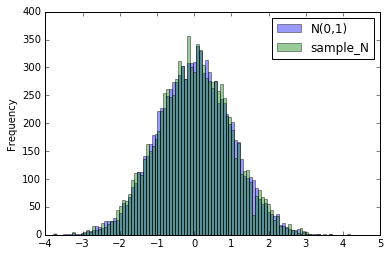

In [289]:
%matplotlib inline
import random
import pandas as pd
import math

N=10000
random.seed(123)

def bernoulli():
    return random.randint(0,1)

# Our sample function of N(0,1) using Equation 5
def sampleN_v1(N=2500):
    return 2.0 * math.sqrt(N) * (sum(bernoulli() for x in range(N)) / N - 0.5)

# Use KS to test again
samples = [sampleN_v1() for x in range(N)]
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("sample_N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Let's plot our samples against our reference distribution
reference = [stats.norm.rvs() for x in range(N)]
pd.DataFrame({'sample_N': samples, 'N(0,1)': reference}).plot(kind='hist', bins=100, alpha=0.4)

Our KS score is somewhat close to \\(0\\) with a p-value that suggests we can't reject our null hypothesis.  Graphing the our implementation of \\(N(0,1)\\) with the reference one shows that we have the roughly the right shape.  No doubt by setting larger \\(N\\) (for both the number of Bernoulli trials and the number of samples drawn), we would get something much closer.  

One large downside of our CLT implementation is that it's *slow*.  While the wall clock time of drawing \\(10000\\) samples using the `numpy` library is unnoticeable, it takes roughly ten seconds on my machine with the parameters above, quite a big difference.  In the next section, we'll see a much more efficient implementation that uses a "trick" to transform a pair of independent uniform random variables to a pair of independent normal random variables.

## Sampling using the Box-Muller Transform

The [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is a neat little "trick" that allows us to sample from a pair of normally distributed variables using only a source of uniformly distributed variables.  The transform is actually pretty simple to compute.  Given two independent uniformly distributed random variables \\(U_1, U_2\\) on the interval \\((0,1)\\), we define two new random variables \\(R and \Theta\\) intuitively representing polar coordinates as such:

\begin{align}
R    &= \sqrt{-2lnU_1}   \tag{6}\\
\Theta &= 2\pi U_2  \tag{7}
\end{align}

Now using the standard transformation from polar coordinates \((R, \Theta\\) to Cartesian ones \\(X, Y\\), we claim that \\(X\\) and \\(Y\\) are independent standard normally distributed random variables:

\begin{align}
X &= Rcos\Theta &= \sqrt{-2lnU_1}cos(2\pi U_2) \tag{8}\\
Y &= Rsin\Theta &= \sqrt{-2lnU_1}sin(2\pi U_2) \tag{9}
\end{align}

Let's sketch the proof to gain some intuition on how this works.

### Proof

Starting with \\(U_1, U_2\\), let's see what kind of distributions we have for \\(R, \Theta\\).  From Equation 7, it should be clear that \\(\Theta\\) is also uniformly distributed since it's just multiplying by a constant (\\(2\pi\\)), but let's go through the motions to explicitly see that.  From the CDF of \\(\Theta\\):

\begin{align}
P(\Theta \leq \theta) &= P(2\pi U_2 \leq \theta) \\
                      &= P(U_2 \leq \frac{\theta}{2\pi}) \\
               \Theta &\sim Uniform(0, 2\pi) \tag{10}
\end{align}

So we have our first result that \\(\Theta\\) is uniformly distributed on \\((0, 2\pi)\\) (as we would expect).  Using a more explicit method, we can find our the distribution of \\(R\\).  From Equation 7, we know that the mapping from \\(U_1\\) to \\(R\\) is one-to-one, which we'll call \\(g\\) (i.e. \\(R=g(U_1)\\)).  So if we're trying to find the probability of R over \\(r_1, r_2\\) (by integrating its PDF), there is some equivalent range in U_1 over \\(g^{-1}(r_1), g^{-1}(r_2)\\) where we can integrate over the PDF of \\(U_1\\).  Let's see how this works [<sup>[3]</sup>](#fn-3):

\begin{align}
P(r_1 \leq R \leq r_2) &=  \int_{g^{-1}(r_2)}^{g^{-1}(r_1)} f_{U_1}(s) ds  && \text{since } g(x) \text{ is strictly decreasing}\\
                       &=  -\int_{g^{-1}(r_1)}^{g^{-1}(r_2)}  ds && \text{since }f_{U_1}(u)=1 \\
                       &=  -\int_{r_1}^{r_2} -t e^{\frac{-t^2}{2}} dt && \text{change variables } t=\sqrt{-2\ln s}\tag{11} \\
                f_R(r) &=  r e^{\frac{-r^2}{2}}  \tag{12}
\end{align}

giving us the PDF for \\(R\\), \\(f_R(r)\\)[<sup>[4]</sup>](#fn-4).  It should also be clear that \\(R\\) and \\(\Theta\\) are independent because \\(U_1\\) and \\(U_2\\) are independent.


Now that we have the distributions for both \\(R\\) and \\(\Theta\\), let's label Equation 8 and 9 as \\(X=g_x(R, \Theta)\\) and \\(Y=g_y(R, \Theta)\\), respectively.  Now we can apply the same procedure as above using variable substitution (for multiple variables) to derive the joint distribution of \\(X\\) and \\(Y\\) :

\begin{align}

P(x_1 &\leq X \leq x_2, y_1 \leq Y \leq y_2) \\
    &= \int_{g_x^{-1}(x_1)}^{g_x^{-1}(x_2)} \int_{g_y^{-1}(y_1)}^{g_y^{-1}(y_2)} f_{R,\Theta}(u, v) du dv \\
    &= \int_{g_x^{-1}(x_1)}^{g_x^{-1}(x_2)} \int_{g_y^{-1}(y_1)}^{g_y^{-1}(y_2)} f_{R}(u)f_{\Theta}(v) du dv && \text{since } R \text{ and } \Theta \text{ are independent} \\ 
    &= \int_{g_x^{-1}(x_1)}^{g_x^{-1}(x_2)} \int_{g_y^{-1}(y_1)}^{g_y^{-1}(y_2)} ue^{\frac{-u^2}{2}}\frac{1}{2\pi} du dv \tag{13}

\end{align}

At this point, we should remember that \\(p=ucos(v), q=usin(v)\\), so solving for \\(u,v\\) results in \\(u=\sqrt{q^2+p^2}, v=arctan(\frac{q}{p})\\).  Also, [substitution for multiple variables](https://en.wikipedia.org/wiki/Integration_by_substitution#Substitution_for_multiple_variables) means that \\(du dv = |det(\frac{\partial(u,v)}{\partial(p, q)})| dp dq\\), plugging our expressions for \\(p\\) and \\(q\\) in:

\begin{align}
du dv &= |det(\frac{\partial(p,q)}{\partial(u, v)})| dp dq \\
      &= 
\left |
\begin{array}{cc}
\frac{\partial u}{\partial p} & \frac{\partial u}{\partial q} \\
\frac{\partial v}{\partial p} & \frac{\partial v}{\partial q}
\end{array}
\right | dpdq \\
      &= 
\left |
\begin{array}{cc}
\frac{\partial \sqrt{q^2+p^2}}{\partial p} & \frac{\partial \sqrt{q^2+p^2}}{\partial q} \\
\frac{\partial arctan(\frac{q}{p})}{\partial p} & \frac{\partial arctan(\frac{q}{p})}{\partial q}
\end{array}
\right | dpdq \\
      &= 
\left |
\begin{array}{cc}
\frac{p}{\sqrt{p^2+q^2}} & \frac{q}{\sqrt{p^2+q^2}} \\
\frac{-q}{p^2(1+(\frac{q}{p})^2)} & \frac{1}{p(1+(\frac{q}{p})^2)}
\end{array}
\right | dpdq \\
      &= \frac{1}{\sqrt{p^2 + q^2}} dpdq \tag{14}

\end{align}

Using the result from Equation 14 into Equation 13, we get:

\begin{align}

P(&x_1 \leq X \leq x_2, y_1 \leq Y \leq y_2) && \text{change variables} \\
    &= \int_{x_1}^{x_2} \int_{y_1}^{y_2} \frac{\sqrt{p^2 + q^2}}{2\pi}\cdot e^{\frac{-(p^2 + q^2)}{2}} \cdot \frac{1}{\sqrt{p^2 + q^2}} dp dq  && p=ucos(v)  \\
    &                     && q=usin(v) \\
    &= \int_{x_1}^{x_2} \underbrace{\frac{1}{\sqrt{2\pi}} e^{\frac{-p^2}{2}}}_{f_X(x)} dp \int_{y_1}^{y_2} \underbrace{\frac{1}{\sqrt{2\pi}} e^{\frac{-q^2}{2}}}_{f_Y(y)} dq  \tag{15}
\end{align}

Equation 15 shows that \\(X\\) and \\(Y\\) are independent each with PDF matching our standard normal distribution \\(N(0,1)\\) as required.

### Implementing Box-Muller Transform

The implementation is a relatively straight forward application of Equation 8 and 9:


sample_N(0,1) vs. N(0, 1): KS=0.0074 with p-value = 0.6372.


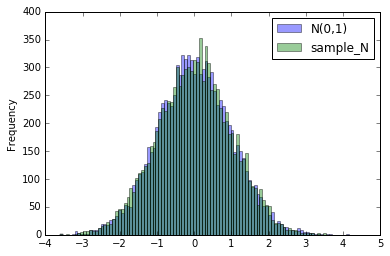

In [288]:
import sys
N=10000
random.seed(123)
epsilon = sys.float_info.epsilon

def box_muller():
    # Avoid getting u == 0.0
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random()
        u2 = random.random()
        
    n1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    n2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return n1, n2


# Use KS to test
samples = [box_muller()[0] for x in range(N)]
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("sample_N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Plot our samples against our reference distribution
reference = [stats.norm.rvs() for x in range(N)]
pd.DataFrame({'sample_N': samples, 'N(0,1)': reference}).plot(kind='hist', bins=100, alpha=0.4)

As we can see, our Box-Muller method of sampling from \\( N(0,1) \\) generates quite good results.  Our KS test statistic is quite small along with a large p-value (that we can't reject our null hypothesis).  Similarly, the graph shows the expected shape matching our reference distribution.  The one big advantage this method has though is that it's quite fast.  There's no noticeable lag when generating \(N=10000\) samples.

## Conclusion

Generating pseudo-random numbers according to various probability distributions has many applications, for example, in Markov Chain Monte Carlo (MCMC) techniques.  In this post, we looked at one of the most fundamental distributions: the standard normal distribution.  Our naive method uses a result directly from the central limit theorem which results in an inefficient implementation.  However with a bit of grit and calculus, we were able to show that the Box-Muller transform provides a much more elegant solution to sampling from a standard normal distribution leading us to an efficient implementation.  Hopefully this sheds some light on how to sample from a normal distribution.

## References and Further Reading


* Wikipedia: [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution), [Box-Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform), [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), [Substitution for multiple variables](https://en.wikipedia.org/wiki/Integration_by_substitution#Substitution_for_multiple_variables), [Determinant of 2x2 matrices](https://en.wikipedia.org/wiki/Determinant#2.C2.A0.C3.97.C2.A02_matrices), [Jacobian matrix and determinant](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)
* Stack Exchange: [How to sample from a normal distribution with known mean and variance using a conventional programming language?](http://stats.stackexchange.com/questions/16334/how-to-sample-from-a-normal-distribution-with-known-mean-and-variance-using-a-co), [Proof of Box-Muller method](http://math.stackexchange.com/questions/1110168/proof-of-the-box-muller-method)
* [Transformations of Random Variables](http://www.math.uah.edu/stat/dist/Transformations.html) (University of Alabama Huntsville)
* [Change of Variables](http://tutorial.math.lamar.edu/Classes/CalcIII/ChangeOfVariables.aspx) (Paul's Online Math Notes)
* [Simple Sampling of Gaussians](http://www.math.nyu.edu/faculty/goodman/teaching/MonteCarlo2005/notes/GaussianSampling.pdf) (Jonathan Goodman, NYU)


## Notes

List of Notes: [^1], [^2], [^3]

[^1]: We'll use the convention of \\(f_X(x)\\) and \\(F_X(x)\\) to denote the PDF and CDF of random variable X, respectively.

[^2]: If we got back to the definitions of mean and variance, we can see this shifting and scaling yields the correct result.  \\(E(\frac{\sqrt{n}(S_n - \mu)}{\sigma}) = \frac{\sqrt{n}(E(S_n) - \mu)}{\sigma} = 0\\) since \\(E(S_n)=\mu\\) by definition.  And \\(Var(\frac{\sqrt{n}(S_n - \mu)}{\sigma}) = \frac{n}{\sigma^2}(E((S_n - \mu)^2) - (E(S_n - \mu))^2 = \frac{n}{\sigma^2} \frac{\sigma^2}{n} = 1 \\)

[^3]: We use \\(s, t\\) for the dummy variables of \\(U_1, R\\) respectively.  You might also need a refresher on [integration by substitution](https://en.wikipedia.org/wiki/Integration_by_substitution) like I did.  Also notice that we flipped the integral endpoints of \\(g^{-1}(r1)\\) and \\(g^{-1}(r2)\\) because \\(g(x)\\) is a strictly decreasing function, so the lower limit \\(r_1\\) maps to the upper limit \\(g^{-1}(r_1)\\) in the transformed function.  Similarly with \\(r_2\\) and \\(g^{-1}(r_2)\\).


## References and Further Reading


* Wikipedia: [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution), [Box-Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform), [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), [Substitution for multiple variables](https://en.wikipedia.org/wiki/Integration_by_substitution#Substitution_for_multiple_variables), [Determinant of 2x2 matrices](https://en.wikipedia.org/wiki/Determinant#2.C2.A0.C3.97.C2.A02_matrices), [Jacobian matrix and determinant](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)
* Stack Exchange: [How to sample from a normal distribution with known mean and variance using a conventional programming language?](http://stats.stackexchange.com/questions/16334/how-to-sample-from-a-normal-distribution-with-known-mean-and-variance-using-a-co), [Proof of Box-Muller method](http://math.stackexchange.com/questions/1110168/proof-of-the-box-muller-method)
* [Transformations of Random Variables](http://www.math.uah.edu/stat/dist/Transformations.html) (University of Alabama Huntsville)
* [Change of Variables](http://tutorial.math.lamar.edu/Classes/CalcIII/ChangeOfVariables.aspx) (Paul's Online Math Notes)
* [Simple Sampling of Gaussians](http://www.math.nyu.edu/faculty/goodman/teaching/MonteCarlo2005/notes/GaussianSampling.pdf) (Jonathan Goodman, NYU)


## Notes

List of Notes: [^1], [^2], [^3], [^4]

[^1]: We'll use the convention of \\(f_X(x)\\) and \\(F_X(x)\\) to denote the PDF and CDF of random variable X, respectively.

[^2]: If we got back to the definitions of mean and variance, we can see this shifting and scaling yields the correct result.  \\(E(\frac{\sqrt{n}(S_n - \mu)}{\sigma}) = \frac{\sqrt{n}(E(S_n) - \mu)}{\sigma} = 0\\) since \\(E(S_n)=\mu\\) by definition.  And \\(Var(\frac{\sqrt{n}(S_n - \mu)}{\sigma}) = \frac{n}{\sigma^2}(E((S_n - \mu)^2) - (E(S_n - \mu))^2 = \frac{n}{\sigma^2} \frac{\sigma^2}{n} = 1 \\)

[^3]: We use \\(s, t\\) for the dummy variables of \\(U_1, R\\) respectively.  You might also need a refresher on [integration by substitution](https://en.wikipedia.org/wiki/Integration_by_substitution) like I did.  Also notice that we flipped the integral endpoints of \\(g^{-1}(r1)\\) and \\(g^{-1}(r2)\\) because \\(g(x)\\) is a strictly decreasing function, so the lower limit \\(r_1\\) maps to the upper limit \\(g^{-1}(r_1)\\) in the transformed function.  Similarly with \\(r_2\\) and \\(g^{-1}(r_2)\\).

[^4]: Our result is actually a specific case of a more general result when transforming from one probability distribution.  Take a look at [Transformations of Random Variables](http://www.math.uah.edu/stat/dist/Transformations.html) for more details and examples.
    
    